# Dynamic Time Warping

### Calculate DTW similarity measure of two time series

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from tslearn.metrics import dtw

from scipy.spatial.distance import cdist

%run dtw_utils.py

## Import time series

####    &emsp;- Separate time series by strain
####    &emsp;- Filter genes that don't exceed 20 TPM at any time point for each strain's time series

In [2]:
ts = pd.read_csv("/Users/joe/Jupyter/Sickle-trait_RNA-seq/salmonQuant/data/counts/TPMs.csv")
ts = ts.rename(columns = {'Unnamed: 0':'ORF'})
ts = ts.set_index('ORF')

ts_3D7 = ts.iloc[:,:64].copy()
ts_FUP = ts.iloc[:,64:128].copy()

ts_3D7 = ts_3D7[(ts_3D7 > 5).any(1)]
ts_FUP = ts_FUP[(ts_FUP > 5).any(1)]

idx_3D7 = list(ts_3D7.index)
idx_FUP = list(ts_FUP.index)

time_points = list(range(3, 51, 3))

### Split the time series by individual isolate

In [3]:
geneSet = idx_3D7
AA13_3D7_dtw = getGenes(ts, '(AA13.*3D7)', geneSet)
AA17_3D7_dtw = getGenes(ts, '(AA17.*3D7)', geneSet)
AS15_3D7_dtw = getGenes(ts, '(AS15.*3D7)', geneSet)
AS16_3D7_dtw = getGenes(ts, '(AS16.*3D7)', geneSet)

geneSet = idx_FUP
AA13_FUP_dtw = getGenes(ts, '(AA13.*FUP)', geneSet)
AA17_FUP_dtw = getGenes(ts, '(AA17.*FUP)', geneSet)
AS18_FUP_dtw = getGenes(ts, '(AS18.*FUP)', geneSet)
AS19_FUP_dtw = getGenes(ts, '(AS19.*FUP)', geneSet)

#### If DTW has already been calculated and results have been merged, read in .csv file for each strain to DataFrame

In [4]:
dtw_3D7 = pd.read_csv("DTW_scores/compiled/3D7_DTW.csv", index_col="ORF")
dtw_FUP = pd.read_csv("DTW_scores/compiled/FUP_DTW.csv", index_col="ORF")

### Calculate Dynamic Time Warping scores for each pairwise comparison

In [6]:
AA13vAA17_3D7 = dtw_df(AA13_3D7_dtw, AA17_3D7_dtw, time_points, "AA13vAA17_3D7")
AA13vAS15_3D7 = dtw_df(AA13_3D7_dtw, AS15_3D7_dtw, time_points, "AA13vAS15_3D7")
AA13vAS16_3D7 = dtw_df(AA13_3D7_dtw, AS16_3D7_dtw, time_points, "AA13vAS16_3D7")
AA17vAS15_3D7 = dtw_df(AA17_3D7_dtw, AS15_3D7_dtw, time_points, "AA17vAS15_3D7")
AA17vAS16_3D7 = dtw_df(AA17_3D7_dtw, AS16_3D7_dtw, time_points, "AA17vAS16_3D7")
AS15vAS16_3D7 = dtw_df(AS15_3D7_dtw, AS16_3D7_dtw, time_points, "AS15vAS16_3D7")

AA13vAA17_FUP = dtw_df(AA13_FUP_dtw, AA17_FUP_dtw, time_points, "AA13vAA17_FUP")
AA13vAS18_FUP = dtw_df(AA13_FUP_dtw, AS18_FUP_dtw, time_points, "AA13vAS18_FUP")
AA13vAS19_FUP = dtw_df(AA13_FUP_dtw, AS19_FUP_dtw, time_points, "AA13vAS19_FUP")
AA17vAS18_FUP = dtw_df(AA17_FUP_dtw, AS18_FUP_dtw, time_points, "AA17vAS18_FUP")
AA17vAS19_FUP = dtw_df(AA17_FUP_dtw, AS19_FUP_dtw, time_points, "AA17vAS19_FUP")
AS18vAS19_FUP = dtw_df(AS18_FUP_dtw, AS19_FUP_dtw, time_points, "AS18vAS19_FUP")

### Merge DTW results from each comparison into one table for each parasite strain

#### &emsp; -Calculate mean DTW score of AAvAS comparisons and save in new column of DataFrame

#### &emsp; -Write results to .csv file

In [6]:
dtw_3D7 = AA13vAA17_3D7.merge(AA13vAS15_3D7[['AA13vAS15_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AA13vAS16_3D7[['AA13vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AA17vAS15_3D7[['AA17vAS15_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AA17vAS16_3D7[['AA17vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7 = dtw_3D7.merge(AS15vAS16_3D7[['AS15vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7['AAvAS_mean'] = dtw_3D7[['AA13vAS15_3D7', 'AA13vAS16_3D7', 'AA17vAS15_3D7', 'AA17vAS16_3D7']].mean(axis=1)
dtw_3D7 = dtw_3D7.sort_values(by='AAvAS_mean', ascending = True)
dtw_3D7.to_csv("DTW_scores/compiled/3D7_DTW_5tpm.csv")

dtw_FUP = AA13vAA17_FUP.merge(AA13vAS18_FUP[['AA13vAS18_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AA13vAS19_FUP[['AA13vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AA17vAS18_FUP[['AA17vAS18_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AA17vAS19_FUP[['AA17vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP = dtw_FUP.merge(AS18vAS19_FUP[['AS18vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP['AAvAS_mean'] = dtw_FUP[['AA13vAS18_FUP', 'AA13vAS19_FUP', 'AA17vAS18_FUP', 'AA17vAS19_FUP']].mean(axis=1)
dtw_FUP = dtw_FUP.sort_values(by='AAvAS_mean', ascending = True)
dtw_FUP.to_csv("DTW_scores/compiled/FUP_DTW_5tpm.csv")

NameError: name 'AA13vAA17_3D7' is not defined

### Make density plot of DTW scores for all comparisons

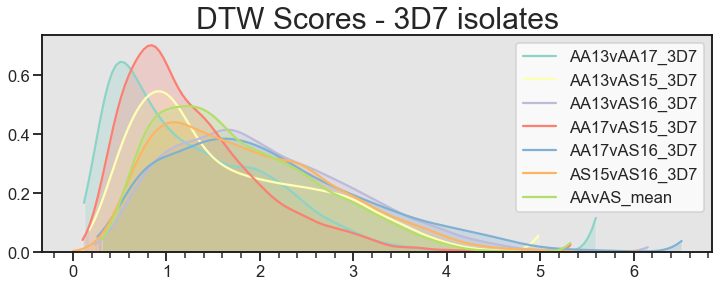

In [5]:
sns.set_palette("Set3")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": "1.9", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(12,4))
data = dtw_3D7
names = data.columns.tolist()
for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='white')
plt.title('DTW Scores - 3D7 isolates', fontsize=30)
plt.savefig("Figures/DTWscores_densityplot_3D7_5tpm.png")

## Draw ridgeplot of 3D7 DTW scores

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


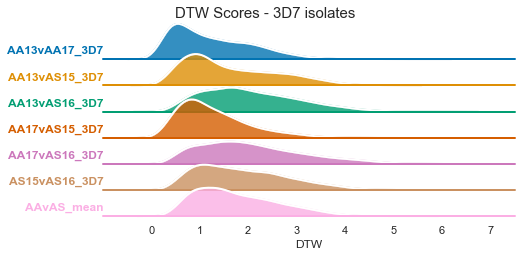

In [6]:
df_3D7 = dtw_3D7.reset_index()
df_3D7 = df_3D7.melt(id_vars=['ORF'] , var_name='Comparison', value_name='DTW')
g = ridgeplot(df_3D7, "DTW Scores - 3D7 isolates")
plt.savefig("Figures/3D7_DTWscores_ridgeplot_5tpm.pdf")

In [7]:
data.head()

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
ORF,,,,,,,
PF3D7_0935600,0.146102,0.262124,0.349445,0.247423,0.378878,0.226622,0.309468
PF3D7_0102200,0.521814,0.257673,0.314477,0.312334,0.495623,0.257594,0.345027
PF3D7_1342600,0.454260,0.176446,0.366663,0.441979,0.442519,0.397450,0.356902
PF3D7_1207500,0.359569,0.344102,0.397717,0.245152,0.452974,0.482771,0.359986
PF3D7_1326000,0.206665,0.331263,0.433392,0.319762,0.477917,0.469556,0.390583


### Summarize the central tendency, dispersion and shape of the 3D7 DTW dataset

In [9]:
stats_3D7 = dtw_3D7.describe()
stats_3D7

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
count,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4.048000e+03,4048.000000
mean,1.245301,1.637448,2.041717,1.281251,2.079203,1.885151e+00,1.759905
std,0.800327,0.938294,0.964572,0.722417,1.066615,9.325780e-01,0.832606
min,0.119090,0.176446,0.232816,0.103595,0.263622,4.933939e-16,0.309468
25%,0.563672,0.880039,1.285413,0.755215,1.269892,1.120601e+00,1.094928
50%,1.050951,1.375962,1.900305,1.109329,1.907430,1.748729e+00,1.597425
75%,1.816043,2.328713,2.675165,1.663365,2.732381,2.505142e+00,2.318455
max,5.595590,4.979727,6.151226,5.323310,6.512863,6.045640e+00,5.323417


In [8]:
(dtw_3D7['AAvAS_mean'].std() * 2) + dtw_3D7['AAvAS_mean'].mean()

3.425116375983489

### Identify genes with the highest DTW scores HbAAvHbAS in 3D7

#### &emsp; (((AAvAS_mean/AAvAA) > 2) & (AAvAS_mean > 2)))

In [20]:
warp_topAS_3D7 = dtw_3D7.copy()
warp_topAS_3D7 = warp_topAS_3D7[((warp_topAS_3D7['AAvAS_mean'])/(warp_topAS_3D7['AA13vAA17_3D7']) > 2) & (warp_topAS_3D7['AAvAS_mean'] > 2)]
warp_topAS_3D7.to_csv('DTW_scores/CandidateGenes/warp_topAS_3D7_DTW_ASvAA>2_2xAA_5tpm.csv', index=True)

thresh = (dtw_3D7['AAvAS_mean'].std() * 2) + dtw_3D7['AAvAS_mean'].mean()
# warp_thresh_3D7 = dtw_3D7[(dtw_3D7['AAvAS_mean'] > thresh) & ((warp_topAS_3D7['AAvAS_mean'])/(warp_topAS_3D7['AA13vAA17_3D7']) > 1.5)]
warp_thresh_3D7 = dtw_3D7[dtw_3D7['AAvAS_mean'] > thresh]
warp_thresh_3D7.to_csv('DTW_scores/CandidateGenes/warp_thresh_3D7_DTW_5tpm.csv', index=True)

warp_topAS_3D7.sort_values(by = 'AAvAS_mean', ascending=False)#.head(n=20)

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
ORF,,,,,,,
PF3D7_1216900,2.129506,4.345257,5.115797,3.341273,5.689006,4.248782,4.622833
PF3D7_1330800,1.870951,3.141714,5.397279,2.889027,5.631782,3.791848,4.264951
PF3D7_0703500,1.921322,3.383356,4.660257,3.225676,5.234867,3.917501,4.126039
PF3D7_1411000.2,0.703523,3.011397,4.982769,3.244195,5.075151,3.526101,4.078378
PF3D7_0402400,1.773844,3.978146,4.114210,3.720400,4.363850,2.483690,4.044152
...,...,...,...,...,...,...,...
PF3D7_1310500,0.706785,1.455742,2.624844,1.206289,2.774259,2.588103,2.015283
PF3D7_0209400,0.942276,1.032551,3.140215,0.612776,3.267154,3.575265,2.013174
PF3D7_0313300,0.382235,1.112976,2.943377,0.983129,3.001850,3.192956,2.010333


### Identify transcripts with low DTW scores in 3D7

In [21]:
low_dtw = int(dtw_3D7['AAvAS_mean'].size * .05)
warp_conserved_thresh_3D7 = dtw_3D7.nsmallest(low_dtw,'AAvAS_mean')
warp_conserved_thresh_3D7.to_csv('DTW_scores/CandidateGenes/warp_conserved_thresh_3D7_DTW_5tpm.csv', index=True)
warp_conserved_thresh_3D7.sort_values(by = 'AAvAS_mean', ascending=True)#.head(n=20)

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean
ORF,,,,,,,
PF3D7_0935600,0.146102,0.262124,0.349445,0.247423,0.378878,0.226622,0.309468
PF3D7_0102200,0.521814,0.257673,0.314477,0.312334,0.495623,0.257594,0.345027
PF3D7_1342600,0.454260,0.176446,0.366663,0.441979,0.442519,0.397450,0.356902
PF3D7_1207500,0.359569,0.344102,0.397717,0.245152,0.452974,0.482771,0.359986
PF3D7_1326000,0.206665,0.331263,0.433392,0.319762,0.477917,0.469556,0.390583
...,...,...,...,...,...,...,...
PF3D7_0205900,0.420182,0.858661,0.656331,0.637557,0.530393,0.739886,0.670736
PF3D7_0632800,0.693850,0.790431,0.892683,0.370678,0.631591,0.520307,0.671346
PF3D7_0308100,0.504638,0.927332,0.796702,0.567625,0.393999,0.596587,0.671415


### Plot gene expression and warping path on heatmap for a gene of interest's time series

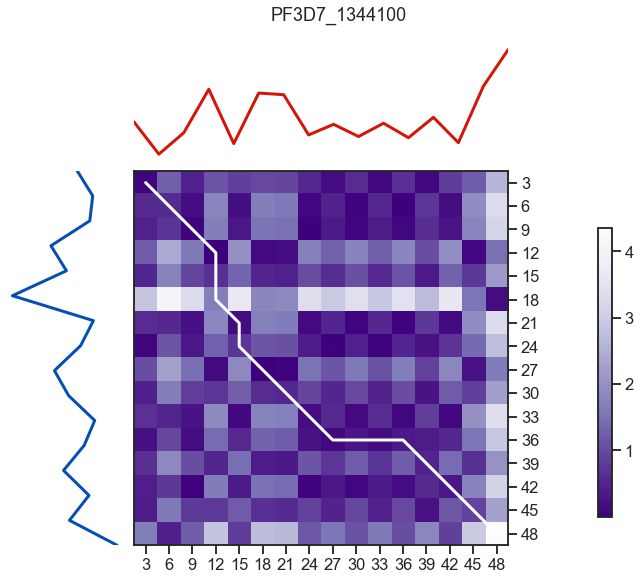

In [12]:
orf = 'PF3D7_1344100'
pathmap(AA17_3D7_dtw, AS16_3D7_dtw, orf, time_points)

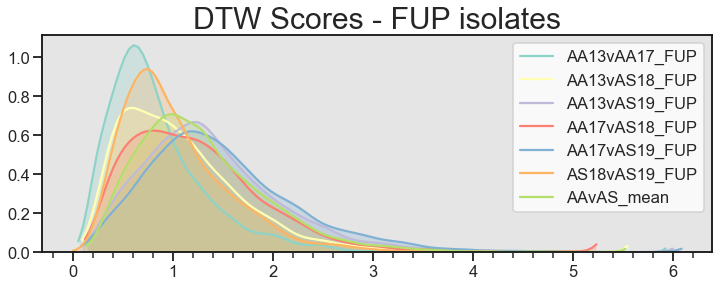

In [13]:
sns.set_palette("Set3")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": "1.9", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(12,4))
data = dtw_FUP
names = data.columns.tolist()
for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='white')
plt.title('DTW Scores - FUP isolates', fontsize=30)
plt.savefig("Figures/DTWscores_densityplot_FUP_5tpm.png")

## Draw ridgeplot of FUP DTW scores

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


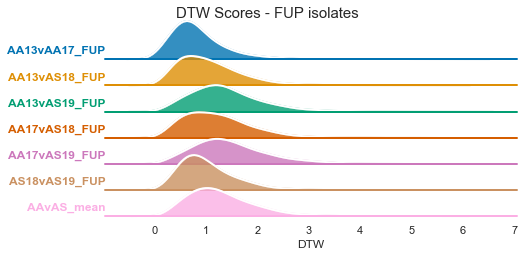

In [14]:
df_FUP = dtw_FUP.reset_index()
df_FUP = df_FUP.melt(id_vars=['ORF'] , var_name='Comparison', value_name='DTW')
g = ridgeplot(df_FUP, "DTW Scores - FUP isolates")
plt.savefig("Figures/FUP_DTWscores_ridgeplot_5tpm.pdf")

### Summarize the central tendency, dispersion and shape of the FUP DTW dataset

In [15]:
stats_FUP = dtw_FUP.describe()
stats_FUP

,AA13vAA17_FUP,AA13vAS18_FUP,AA13vAS19_FUP,AA17vAS18_FUP,AA17vAS19_FUP,AS18vAS19_FUP,AAvAS_mean
count,4657.000000,4657.000000,4657.000000,4657.000000,4657.000000,4657.000000,4657.000000
mean,0.837515,1.081079,1.389257,1.226875,1.484466,1.031781,1.295419
std,0.524642,0.648128,0.717585,0.683276,0.757618,0.560490,0.659349
min,0.053819,0.091133,0.089881,0.120910,0.082916,0.000000,0.135178
25%,0.487894,0.602746,0.899809,0.716929,0.962956,0.639230,0.826645
50%,0.720483,0.953026,1.278647,1.128719,1.360014,0.903479,1.184372
75%,1.058879,1.401230,1.752053,1.587086,1.869729,1.299515,1.642238
max,5.926431,5.544698,5.995735,5.233894,6.085142,5.008385,5.521533


### Identify genes with the highest DTW scores HbAAvHbAS in FUP

#### &emsp; (((AAvAS_mean/AAvAA) > 2) & (AAvAS_mean > 2)))

In [23]:
warp_topAS_FUP = dtw_FUP.copy()
warp_topAS_FUP = warp_topAS_FUP[((warp_topAS_FUP['AAvAS_mean'])/(warp_topAS_FUP['AA13vAA17_FUP']) > 2) & (warp_topAS_FUP['AAvAS_mean'] > 2)]
warp_topAS_FUP.to_csv('DTW_scores/CandidateGenes/warp_topAS_FUP_DTW_ASvAA>2_2xAA_5tpm.csv', index=True)

thresh = (dtw_FUP['AAvAS_mean'].std() * 2) + dtw_FUP['AAvAS_mean'].mean()
warp_thresh_FUP = dtw_FUP[dtw_FUP['AAvAS_mean'] > thresh]
warp_thresh_FUP.to_csv('DTW_scores/CandidateGenes/warp_thresh_FUP_DTW_5tpm.csv', index=True)

warp_topAS_FUP.sort_values(by = 'AAvAS_mean', ascending=False)#.head(n=20)

,AA13vAA17_FUP,AA13vAS18_FUP,AA13vAS19_FUP,AA17vAS18_FUP,AA17vAS19_FUP,AS18vAS19_FUP,AAvAS_mean
ORF,,,,,,,
PF3D7_1002500,1.872893,4.853448,4.845913,4.715337,4.539231,2.336559,4.738482
PF3D7_0206600,1.094027,4.878316,4.394422,4.654751,4.326795,2.827257,4.563571
PF3D7_0212200,1.777271,3.722635,4.820086,3.947716,4.755689,2.395729,4.311531
PF3D7_0702600,1.936870,4.743038,3.423752,4.946421,3.258694,2.533079,4.092976
PF3D7_1415800,1.671357,3.042693,3.958146,3.545466,4.004400,2.308073,3.637676
...,...,...,...,...,...,...,...
PF3D7_1215100,0.745686,1.721006,2.048121,1.990298,2.342566,0.596436,2.025498
PF3D7_0409400,0.602415,1.777534,1.909319,2.107910,2.299754,0.488509,2.023629
PF3D7_1020500,0.939060,1.763499,1.991913,2.069891,2.267402,0.824080,2.023176


### Identify transcripts with low DTW scores in FUP

In [22]:
low_dtw = int(dtw_FUP['AAvAS_mean'].size * .05)
warp_conserved_thresh_FUP = dtw_FUP.nsmallest(low_dtw,'AAvAS_mean')
warp_conserved_thresh_FUP.to_csv('DTW_scores/CandidateGenes/warp_conserved_thresh_FUP_DTW_5tpm.csv', index=True)
warp_conserved_thresh_FUP.sort_values(by = 'AAvAS_mean', ascending=True)#.head(n=20)

,AA13vAA17_FUP,AA13vAS18_FUP,AA13vAS19_FUP,AA17vAS18_FUP,AA17vAS19_FUP,AS18vAS19_FUP,AAvAS_mean
ORF,,,,,,,
PF3D7_0935600,0.110630,0.112569,0.089881,0.147386,0.190877,0.148853,0.135178
PF3D7_1361700,0.235256,0.112223,0.252407,0.186544,0.082916,0.229603,0.158523
PF3D7_1149200,0.138744,0.181926,0.196577,0.147237,0.239219,0.126055,0.191239
PF3D7_0902500,0.265905,0.151187,0.140810,0.273175,0.311376,0.173377,0.219137
PF3D7_1439400,0.242526,0.112408,0.258224,0.178785,0.327629,0.291306,0.219262
...,...,...,...,...,...,...,...
PF3D7_1034700,0.141548,0.492308,0.365374,0.360692,0.477041,0.799611,0.423853
PF3D7_1033900,0.472540,0.631296,0.237486,0.250776,0.586285,0.716787,0.426461
PF3D7_1443700,0.303994,0.489238,0.513832,0.460315,0.244780,0.532511,0.427041


### Plot gene expression and warping path on heatmap for a gene of interest's time series

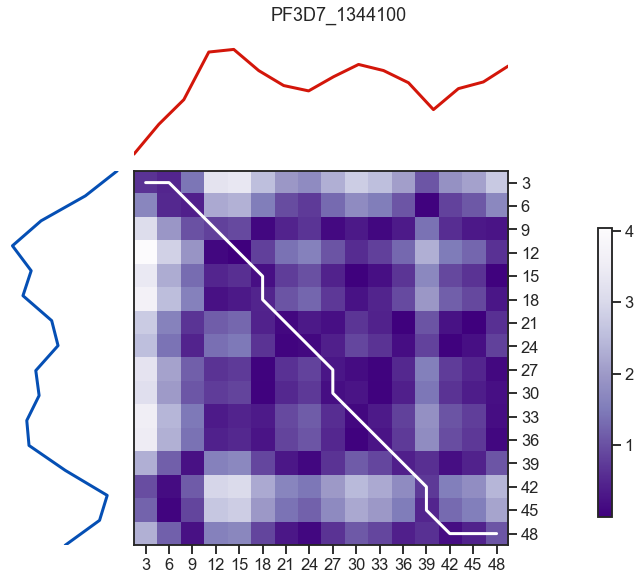

In [18]:
orf = 'PF3D7_1344100'
pathmap(AA13_FUP_dtw, AS18_FUP_dtw, orf, time_points)

### Plot boxen distributions of 3D7 DTW scores

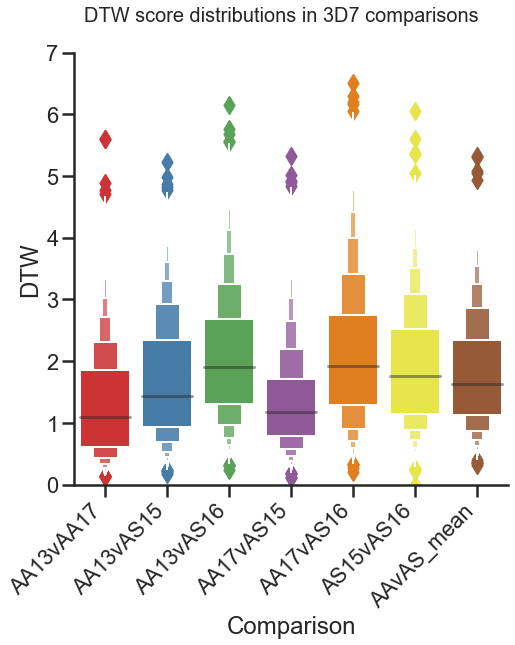

In [19]:
sns.set_context("poster")
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})

g = sns.catplot(
    data=df_3D7,
    x='Comparison', 
    y='DTW', 
    height=8,
    kind = 'boxen',
    palette = 'Set1'
    ) 
plt.ylim(0,7)
plt.suptitle("DTW score distributions in 3D7 comparisons", fontsize=20)
g.set_xticklabels(('AA13vAA17','AA13vAS15', 'AA13vAS16', 'AA17vAS15', 
                   'AA17vAS16','AS15vAS16', 'AAvAS_mean'),
                  rotation=45, horizontalalignment='right')
plt.gcf().subplots_adjust(bottom=0.15, top=0.9)
plt.savefig("Figures/strainDTWscores/3D7_boxen_5tpm.png")

### Plot boxen distributions of FUP DTW scores

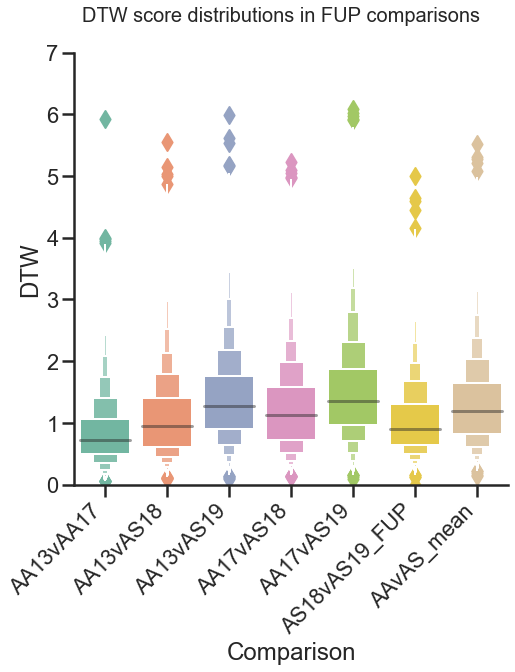

In [20]:
df_FUP = dtw_FUP.reset_index()
df_FUP = df_FUP.melt(id_vars=['ORF'] , var_name='Comparison', value_name='DTW')

sns.set_context("poster")
g = sns.catplot(
    data=df_FUP,
    x='Comparison', 
    y='DTW', 
    height = 8,
    kind = 'boxen',
    palette = 'Set2'
    ) 
plt.suptitle("DTW score distributions in FUP comparisons", fontsize=20)
g.set_xticklabels(('AA13vAA17','AA13vAS18', 'AA13vAS19', 'AA17vAS18', 
                   'AA17vAS19','AS18vAS19_FUP', 'AAvAS_mean'),
                  rotation=45, horizontalalignment='right')
plt.gcf().subplots_adjust(bottom=0.15, top=0.9)
plt.ylim(0,7)
plt.savefig("Figures/strainDTWscores/FUP_boxen_5tpm.png")

#
# &nbsp;Dynamic Time Warping - Sakoe-Chiba radius constraint
#### Setting radius to 0 will calculate the Euclidean distance of two time series

### If DTW with Sakoe-Chiba constraint has already been run, read in compiled file

In [26]:
dtw_3D7_sc = pd.read_csv("DTW_scores/compiled/3D7_DTW_Sakoe-Chiba_radius_0.csv", index_col="ORF")
dtw_FUP_sc = pd.read_csv("DTW_scores/compiled/FUP_DTW_Sakoe-Chiba_radius_0.csv", index_col="ORF")

### Set radius parameter for Sakoe-Chiba DTW analysis

In [27]:
radius = 0

### Calculate Dynamic Time Warping scores for each pairwise comparison with radius constraint

In [19]:
AA13vAA17_3D7_sc = dtw_df_sakoe_chiba(AA13_3D7_dtw, AA17_3D7_dtw, time_points, "AA13vAA17_3D7", radius)
AA13vAS15_3D7_sc = dtw_df_sakoe_chiba(AA13_3D7_dtw, AS15_3D7_dtw, time_points, "AA13vAS15_3D7", radius)
AA13vAS16_3D7_sc = dtw_df_sakoe_chiba(AA13_3D7_dtw, AS16_3D7_dtw, time_points, "AA13vAS16_3D7", radius)
AA17vAS15_3D7_sc = dtw_df_sakoe_chiba(AA17_3D7_dtw, AS15_3D7_dtw, time_points, "AA17vAS15_3D7", radius)
AA17vAS16_3D7_sc = dtw_df_sakoe_chiba(AA17_3D7_dtw, AS16_3D7_dtw, time_points, "AA17vAS16_3D7", radius)
AS15vAS16_3D7_sc = dtw_df_sakoe_chiba(AS15_3D7_dtw, AS16_3D7_dtw, time_points, "AS15vAS16_3D7", radius)

AA13vAA17_FUP_sc = dtw_df_sakoe_chiba(AA13_FUP_dtw, AA17_FUP_dtw, time_points, "AA13vAA17_FUP", radius)
AA13vAS18_FUP_sc = dtw_df_sakoe_chiba(AA13_FUP_dtw, AS18_FUP_dtw, time_points, "AA13vAS18_FUP", radius)
AA13vAS19_FUP_sc = dtw_df_sakoe_chiba(AA13_FUP_dtw, AS19_FUP_dtw, time_points, "AA13vAS19_FUP", radius)
AA17vAS18_FUP_sc = dtw_df_sakoe_chiba(AA17_FUP_dtw, AS18_FUP_dtw, time_points, "AA17vAS18_FUP", radius)
AA17vAS19_FUP_sc = dtw_df_sakoe_chiba(AA17_FUP_dtw, AS19_FUP_dtw, time_points, "AA17vAS19_FUP", radius)
AS18vAS19_FUP_sc = dtw_df_sakoe_chiba(AS18_FUP_dtw, AS19_FUP_dtw, time_points, "AS18vAS19_FUP", radius)

### Merge Sakoe-Chiba DTW results from each comparison into one table for each parasite strain

#### &emsp; -Calculate mean Sakoe-Chiba DTW score of AAvAS comparisons and save in new column of DataFrame

#### &emsp; -Write results to .csv file

In [20]:
dtw_3D7_sc = AA13vAA17_3D7_sc.merge(AA13vAS15_3D7_sc[['AA13vAS15_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7_sc = dtw_3D7_sc.merge(AA13vAS16_3D7_sc[['AA13vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7_sc = dtw_3D7_sc.merge(AA17vAS15_3D7_sc[['AA17vAS15_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7_sc = dtw_3D7_sc.merge(AA17vAS16_3D7_sc[['AA17vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7_sc = dtw_3D7_sc.merge(AS15vAS16_3D7_sc[['AS15vAS16_3D7']], left_index=True, right_index=True, how='inner')
dtw_3D7_sc['AAvAS_mean'] = dtw_3D7_sc[['AA13vAS15_3D7', 'AA13vAS16_3D7', 'AA17vAS15_3D7', 'AA17vAS16_3D7']].mean(axis=1)
dtw_3D7_sc['mean'] = dtw_3D7_sc[['AA13vAA17_3D7', 'AA13vAS15_3D7', 'AA13vAS16_3D7', 'AA17vAS15_3D7', 'AA17vAS16_3D7', 'AS15vAS16_3D7']].mean(axis=1)
dtw_3D7_sc = dtw_3D7_sc.sort_values(by='AAvAS_mean', ascending = True)
dtw_3D7_sc.to_csv("DTW_scores/compiled/3D7_DTW_Sakoe-Chiba_radius_0.csv")

dtw_FUP_sc = AA13vAA17_FUP_sc.merge(AA13vAS18_FUP_sc[['AA13vAS18_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP_sc = dtw_FUP_sc.merge(AA13vAS19_FUP_sc[['AA13vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP_sc = dtw_FUP_sc.merge(AA17vAS18_FUP_sc[['AA17vAS18_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP_sc = dtw_FUP_sc.merge(AA17vAS19_FUP_sc[['AA17vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP_sc = dtw_FUP_sc.merge(AS18vAS19_FUP_sc[['AS18vAS19_FUP']], left_index=True, right_index=True, how='inner')
dtw_FUP_sc['AAvAS_mean'] = dtw_FUP_sc[['AA13vAS18_FUP', 'AA13vAS19_FUP', 'AA17vAS18_FUP', 'AA17vAS19_FUP']].mean(axis=1)
dtw_FUP_sc['mean'] = dtw_FUP_sc[['AA13vAA17_FUP', 'AA13vAS18_FUP', 'AA13vAS19_FUP', 'AA17vAS18_FUP', 'AA17vAS19_FUP', 'AS18vAS19_FUP']].mean(axis=1)
dtw_FUP_sc = dtw_FUP_sc.sort_values(by='AAvAS_mean', ascending = True)
dtw_FUP_sc.to_csv("DTW_scores/compiled/FUP_DTW_Sakoe-Chiba_radius_0.csv")

### Plot individual distributions of Sakoe-Chiba DTW comparisons in 3D7

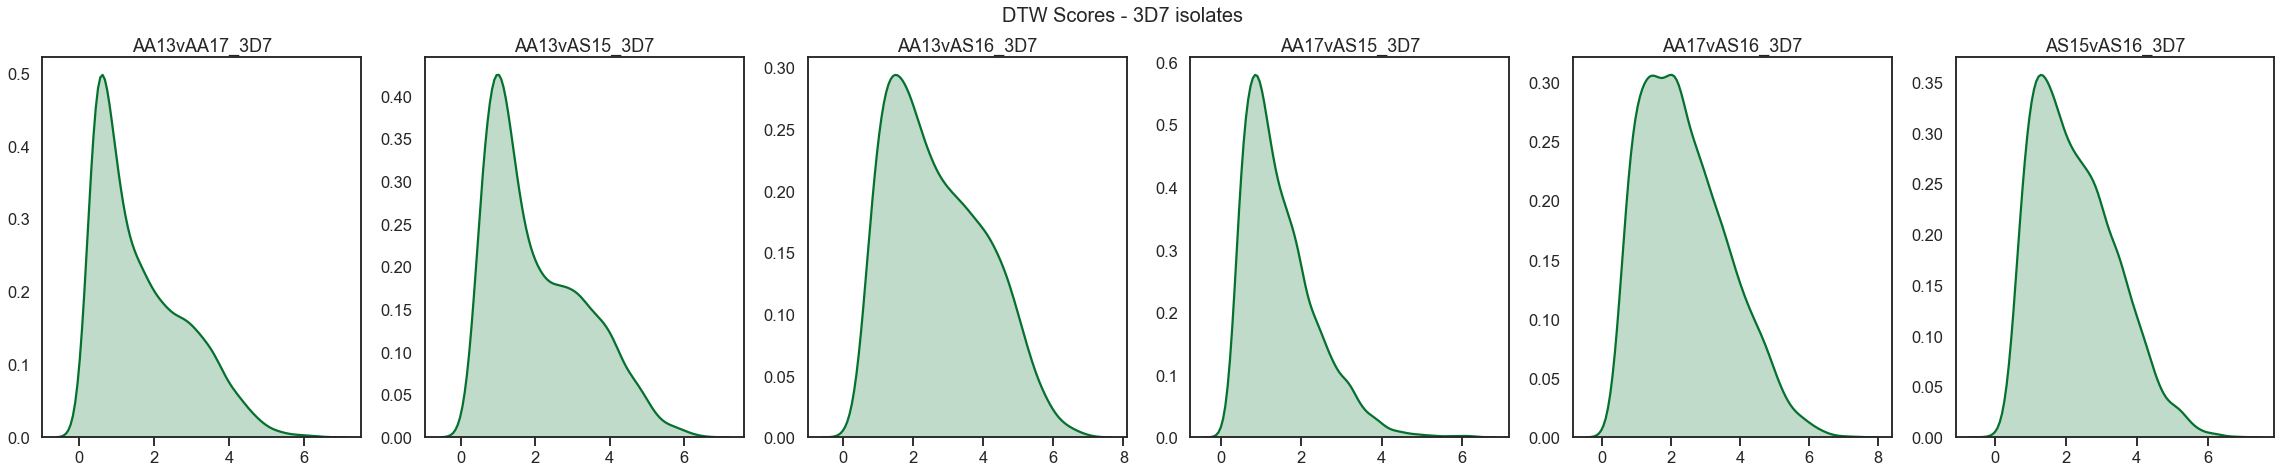

In [21]:
sns.set_palette("Greens_r")
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, nrows=1, figsize=(40, 7))

fig.suptitle('DTW Scores - 3D7 isolates', fontsize=20)

sns.kdeplot(dtw_3D7_sc['AA13vAA17_3D7'].to_numpy(), shade=True, ax=ax1)
ax1.title.set_text('AA13vAA17_3D7')
sns.kdeplot(dtw_3D7_sc['AA13vAS15_3D7'].to_numpy(), shade=True, ax=ax2)
ax2.title.set_text('AA13vAS15_3D7')
sns.kdeplot(dtw_3D7_sc['AA13vAS16_3D7'].to_numpy(), shade=True, ax=ax3)
ax3.title.set_text('AA13vAS16_3D7')
sns.kdeplot(dtw_3D7_sc['AA17vAS15_3D7'].to_numpy(), shade=True, ax=ax4)
ax4.title.set_text('AA17vAS15_3D7')
sns.kdeplot(dtw_3D7_sc['AA17vAS16_3D7'].to_numpy(), shade=True, ax=ax5)
ax5.title.set_text('AA17vAS16_3D7')
sns.kdeplot(dtw_3D7_sc['AS15vAS16_3D7'].to_numpy(), shade=True, ax=ax6)
ax6.title.set_text('AS15vAS16_3D7')

### Make density plot of Sakoe-Chiba DTW scores for all 3D7 comparisons

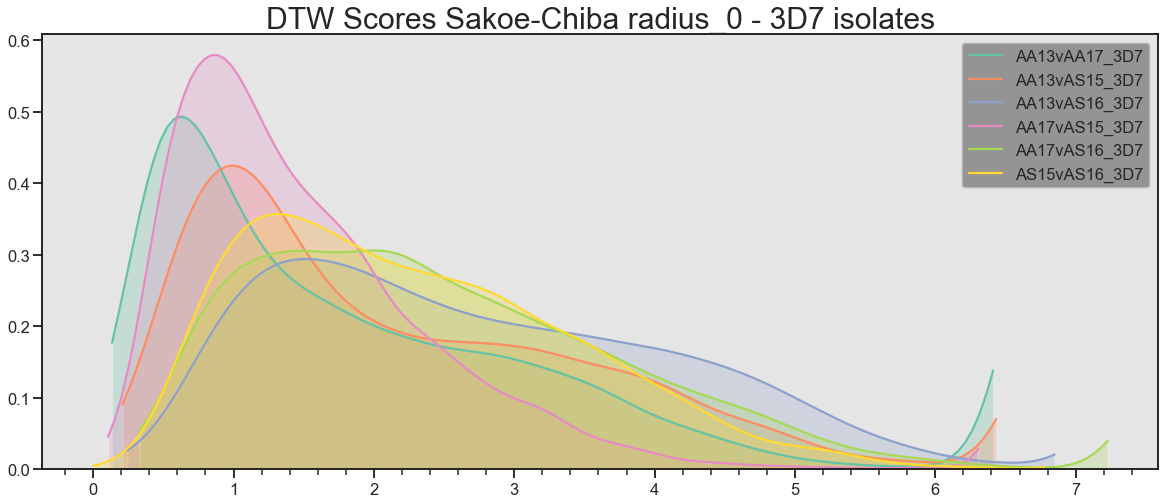

In [15]:
sns.set_palette("Set2")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": "1.9", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(20,8))
data = dtw_3D7_sc.drop(['AAvAS_mean', 'mean'], axis = 1)
names = data.columns.tolist()
for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='gray')
plt.title('DTW Scores Sakoe-Chiba radius_0 - 3D7 isolates', fontsize=30)
plt.savefig("Figures/sakoe_chiba_DTWscores_densityplot_3D7.png")

### Plot individual distributions of Sakoe-Chiba DTW comparisons in FUP

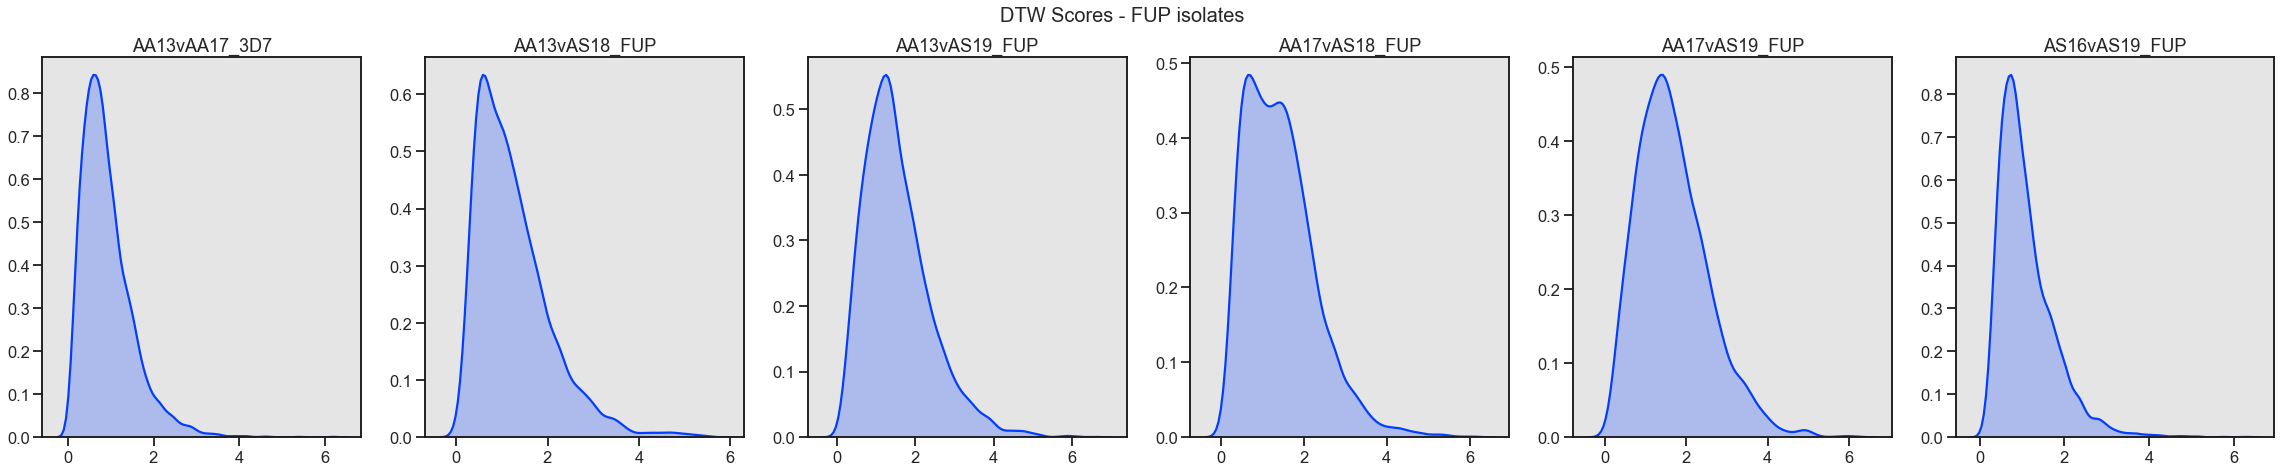

In [24]:
sns.set_palette("bright")
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, nrows=1, figsize=(40, 7))

fig.suptitle('DTW Scores - FUP isolates', fontsize=20)

sns.kdeplot(dtw_FUP_sc['AA13vAA17_FUP'].to_numpy(), shade=True, ax=ax1)
ax1.title.set_text('AA13vAA17_3D7')
sns.kdeplot(dtw_FUP_sc['AA13vAS18_FUP'].to_numpy(), shade=True, ax=ax2)
ax2.title.set_text('AA13vAS18_FUP')
sns.kdeplot(dtw_FUP_sc['AA13vAS19_FUP'].to_numpy(), shade=True, ax=ax3)
ax3.title.set_text('AA13vAS19_FUP')
sns.kdeplot(dtw_FUP_sc['AA17vAS18_FUP'].to_numpy(), shade=True, ax=ax4)
ax4.title.set_text('AA17vAS18_FUP')
sns.kdeplot(dtw_FUP_sc['AA17vAS19_FUP'].to_numpy(), shade=True, ax=ax5)
ax5.title.set_text('AA17vAS19_FUP')
sns.kdeplot(dtw_FUP_sc['AS18vAS19_FUP'].to_numpy(), shade=True, ax=ax6)
ax6.title.set_text('AS16vAS19_FUP')

### Make density plot of Sakoe-Chiba DTW scores for all FUP comparisons

Text(0.5, 1.0, 'DTW Scores Sakoe-Chiba radius_0 - FUP isolates')

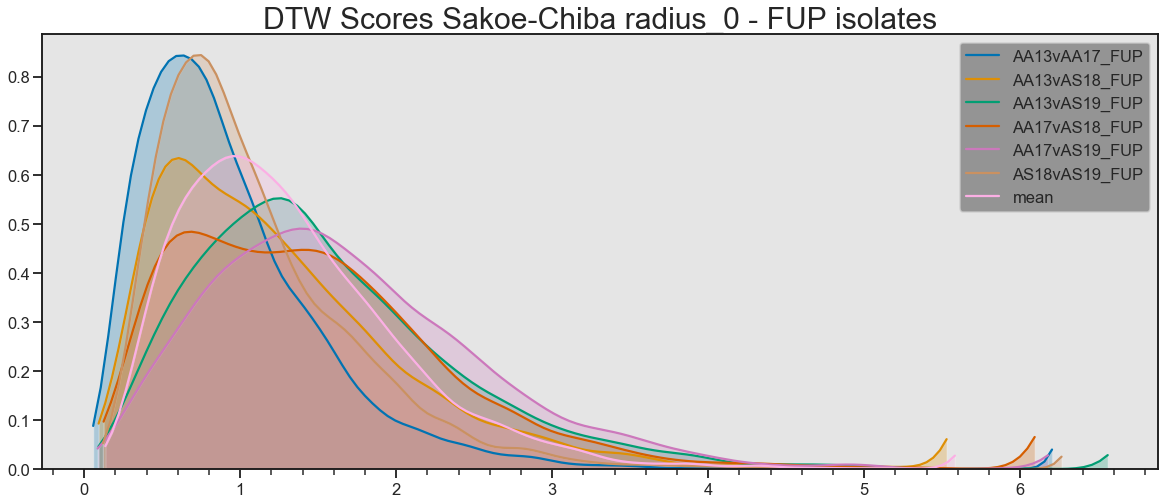

In [25]:
sns.set_palette("colorblind")
sns.set_context("talk")
sns.set_style("dark", {"axes.facecolor": "1.9", 'axes.edgecolor': '.1', 'xtick.bottom': True, 'ytick.left': True})
plt.figure(figsize=(20,8))
data = dtw_FUP_sc.drop(['AAvAS_mean'], axis = 1)
names = data.columns.tolist()

for i in range(len(names)):
    ax = sns.kdeplot(data[names[i]].to_numpy(), shade = True, label = names[i], cut=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(.2))
plt.legend(facecolor='gray')
plt.title('DTW Scores Sakoe-Chiba radius_0 - FUP isolates', fontsize=30)

### Identify genes with the highest Sakoe-Chiba DTW scores HbAAvHbAS in 3D7

#### &emsp; (((AAvAS_mean/AAvAA) > 2) & (AAvAS_mean > 2.5)))

In [30]:
topAS_3D7_sc = dtw_3D7_sc.copy()
topAS_3D7_sc = topAS_3D7_sc[((topAS_3D7_sc['AAvAS_mean'])/(topAS_3D7_sc['AA13vAA17_3D7']) > 2) & (topAS_3D7_sc['AAvAS_mean'] > 2.5)]
topAS_3D7_sc.to_csv('DTW_scores/CandidateGenes/sakoe-chiba_topAS_3D7_DTW_meanAAvAS>2,5_2XAA.csv', index=True)

thresh = (dtw_3D7_sc['AAvAS_mean'].std() * 2) + dtw_3D7_sc['AAvAS_mean'].mean()
thresh_3D7_sc = dtw_3D7_sc[dtw_3D7_sc['AAvAS_mean'] > thresh]
thresh_3D7_sc.to_csv('DTW_scores/CandidateGenes/sakoe-chiba_thresh_3D7_DTW.csv', index=True)
thresh_3D7_sc.sort_values(by = 'AAvAS_mean', ascending=False)

,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean,mean
ORF,,,,,,,,
PF3D7_0913000,3.672569,6.434396,6.828642,6.304788,7.228420,5.431171,6.699062,5.983331
PF3D7_1109900,5.309972,6.346701,6.526886,5.327736,6.485848,5.350391,6.171793,5.891256
PF3D7_0108300,4.439995,5.176771,6.296906,6.147729,6.650263,4.994494,6.067917,5.617693
PF3D7_0113400,3.786849,5.704325,6.357984,5.710138,6.418881,2.923169,6.047832,5.150224
PF3D7_1103900,6.056501,5.997488,5.820388,5.964298,6.074514,4.778484,5.964172,5.781946
...,...,...,...,...,...,...,...,...
PF3D7_1472100,5.062911,5.414503,5.004933,2.239669,4.933654,4.574729,4.398190,4.538400
PF3D7_0310600.1,3.238348,5.003607,4.970339,4.018622,3.599151,3.701642,4.397930,4.088618
PF3D7_1306800,4.593980,5.092626,5.302023,2.788732,4.404220,3.930920,4.396900,4.352083


### Identify genes with the highest Sakoe-Chiba DTW scores HbAAvHbAS in FUP

#### &emsp; (((AAvAS_mean/AAvAA) > 2) & (AAvAS_mean > 2.5)))

In [32]:
topAS_FUP_sc = dtw_FUP_sc.copy()
topAS_FUP_sc = topAS_FUP_sc[((topAS_FUP_sc['AAvAS_mean'])/(topAS_FUP_sc['AA13vAA17_FUP']) > 2) & (topAS_FUP_sc['AAvAS_mean'] > 2.5)]
topAS_FUP_sc.to_csv('DTW_scores/CandidateGenes/sakoe-chiba_topAS_FUP_DTW_meanAAvAS>2,5_2XAA.csv', index=True)

thresh = (dtw_FUP_sc['AAvAS_mean'].std() * 2) + dtw_FUP_sc['AAvAS_mean'].mean()
thresh_FUP_sc = dtw_FUP_sc[dtw_FUP_sc['AAvAS_mean'] > thresh]
thresh_FUP_sc.to_csv('DTW_scores/CandidateGenes/sakoe-chiba_thresh_FUP_DTW.csv', index=True)
thresh_FUP_sc.sort_values(by = 'AAvAS_mean', ascending=False)

,AA13vAA17_FUP,AA13vAS18_FUP,AA13vAS19_FUP,AA17vAS18_FUP,AA17vAS19_FUP,AS18vAS19_FUP,AAvAS_mean,mean
ORF,,,,,,,,
PF3D7_1103900,4.683425,4.423285,6.560572,5.927768,6.177528,5.711958,5.772288,5.580756
PF3D7_1340200,4.173014,5.095157,5.912304,4.992593,4.989166,5.149327,5.247305,5.051927
PF3D7_1212600.2,3.855657,3.533413,6.058611,5.308239,5.882220,6.264596,5.195621,5.150456
PF3D7_0310600.1,3.589879,5.125730,5.891489,4.860462,4.811686,3.690422,5.172341,4.661611
PF3D7_1453300,4.205093,5.109857,5.744302,3.577280,5.724138,4.571067,5.038894,4.821956
...,...,...,...,...,...,...,...,...
PF3D7_0729500,1.376250,2.906419,2.967411,3.258146,3.243978,1.309102,3.093989,2.510218
PF3D7_1450700,1.836247,2.714082,3.049978,3.167707,3.427317,1.724832,3.089771,2.653361
PF3D7_0626700,1.201348,2.291825,3.242016,3.044032,3.764843,2.091515,3.085679,2.605930


### Plot boxen distributions of 3D7 Sakoe-Chiba DTW scores

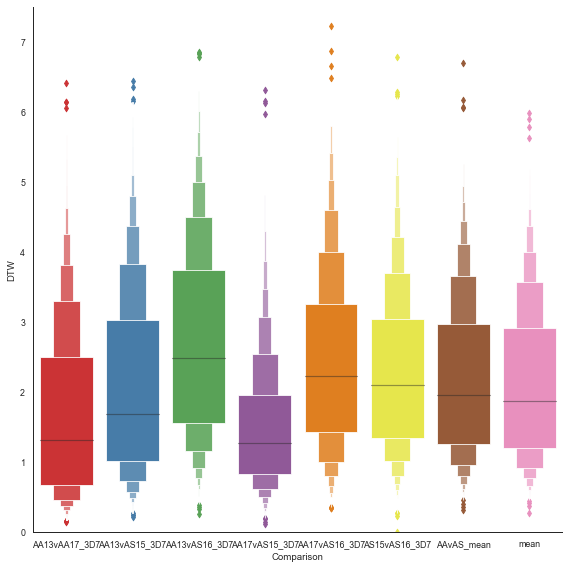

In [32]:
df_3D7_sc = dtw_3D7_sc.reset_index()
df_3D7_sc = df_3D7_sc.melt(id_vars=['ORF'] , var_name='Comparison', value_name='DTW')

sns.set_context("paper")
sns.set_style("white")
g = sns.catplot(
    data=df_3D7_sc,
    x='Comparison', 
    y='DTW', 
    height=8,
    kind = 'boxen',
    palette = 'Set1'
    ) 
plt.ylim(0,7.5)
plt.savefig("Figures/sakoe_chiba_strainDTWscores_3D7.png")

### Plot boxen distributions of FUP Sakoe-Chiba DTW scores

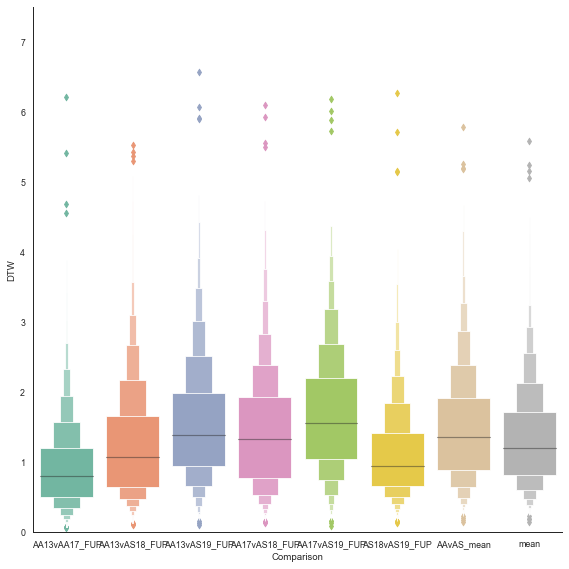

In [33]:
df_FUP_sc = dtw_FUP_sc.reset_index()
df_FUP_sc = df_FUP_sc.melt(id_vars=['ORF'] , var_name='Comparison', value_name='DTW')

sns.set_context("paper")
sns.set_style("white")
g = sns.catplot(
    data=df_FUP_sc,
    x='Comparison', 
    y='DTW', 
    height=8,
    kind = 'boxen',
    palette = 'Set2'
    ) 
plt.ylim(0,7.5)
plt.savefig("Figures/sakoe_chiba_strainDTWscores_FUP.png")

### Plot gene expression and Euclidean distance heatmap for a gene of interest's time series

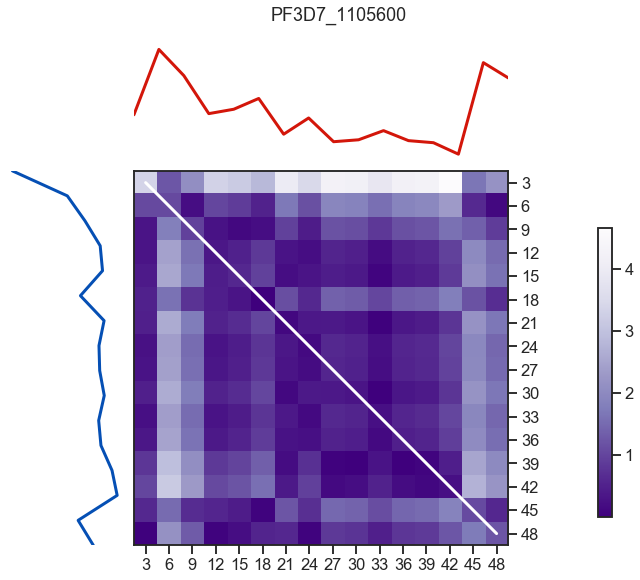

In [40]:
orf = 'PF3D7_1105600'
pathmap_sakoe_chiba(AA17_3D7_dtw, AS15_3D7_dtw, orf, time_points, radius)

## Merge gene annotations

In [20]:
annos = pd.read_csv("/Users/joe/Jupyter/Sickle-trait_RNA-seq/salmonQuant/data/PFD3D7_annos.csv")
annos = annos.drop(['Unnamed: 0'], axis =1)

In [21]:
highAS_3D7_annos = warp_topAS_3D7.merge(annos[['ORF', 'GENENAME']], left_on='ORF', right_on='ORF', how='left')
highAS_FUP_annos = warp_topAS_FUP.merge(annos[['ORF', 'GENENAME']], left_on='ORF', right_on='ORF', how='left')

In [43]:
highAS_3D7_annos.sort_values(by='AAvAS_mean', ascending=False).head(n=5)

,ORF,AA13vAA17_3D7,AA13vAS15_3D7,AA13vAS16_3D7,AA17vAS15_3D7,AA17vAS16_3D7,AS15vAS16_3D7,AAvAS_mean,GENENAME
279,PF3D7_0108300,3.532169,3.996181,5.682507,5.323310,6.291670,4.557548,5.323417,"conserved Plasmodium protein, unknown function"
278,PF3D7_0113400,2.656812,4.829321,5.545535,4.912220,5.953893,2.509563,5.310242,"Plasmodium exported protein, unknown function"
277,PF3D7_1216900,2.129506,4.345257,5.115797,3.341273,5.689006,4.248782,4.622833,"DNA-binding chaperone, putative"
276,PF3D7_1477600,2.589815,3.805124,4.709185,4.331614,5.626432,2.393392,4.618089,surface-associated interspersed protein 14.1 (...
275,PF3D7_1006700,2.443429,4.175438,4.538515,3.943944,5.286793,3.229705,4.486173,"conserved Plasmodium protein, unknown function"


## Plot gene expression in TPMs for all time series

In [33]:
ts = pd.read_csv("/Users/joe/Jupyter/Sickle-trait_RNA-seq/salmonQuant/data/counts/TPMs.csv")
ts = ts.rename(index = str, columns = {"Unnamed: 0" : "ORF"})
sampleTable = pd.read_csv("/Users/joe/Jupyter/Sickle-trait_RNA-seq/salmonQuant/data/sampleTable.csv")
TPMs = ts.melt(id_vars=['ORF'] , var_name='Sample', value_name='TPM')
TPMs = TPMs.merge(sampleTable[['sampleName', 'Genotype', 'HPI', 'Strain', 'Patient', 'ID']], left_on='Sample', right_on='sampleName', how='inner')
TPMs = TPMs.drop('Sample', axis=1)
ts = ts.set_index('ORF')

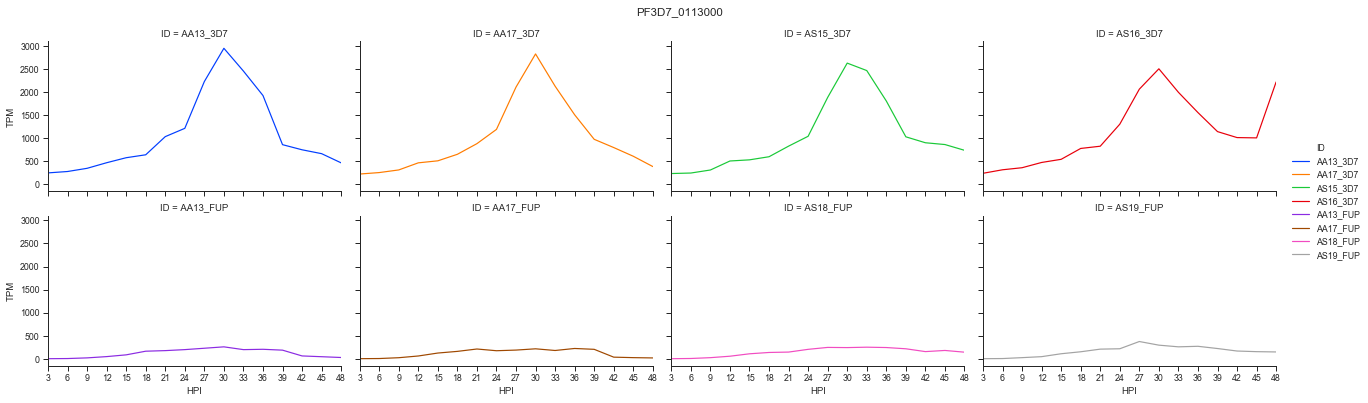

In [34]:
plot(TPMs, 'PF3D7_0113000')